# Train custom2 model for phishing detection

## Imports

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = pathlib.Path("../phi_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

In [3]:
os.listdir(dataset_dir)

['phishing', 'trusted_list']

In [4]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-07-25_20;59;24.692949


## Params

In [5]:
model_name = "custom2"
batch_size = 10
img_height = 512
img_width = 720

rest_split_ratio = 0.2
test_split_ratio = 0.2

## Load dataset

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 8433 files for training.


In [34]:
rest_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 2108 files for validation.


In [35]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

211


In [36]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio // batch_size))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio // batch_size))

In [10]:
class_names = train_ds.class_names

In [11]:
class_names

['phishing', 'trusted_list']

## Visualize data

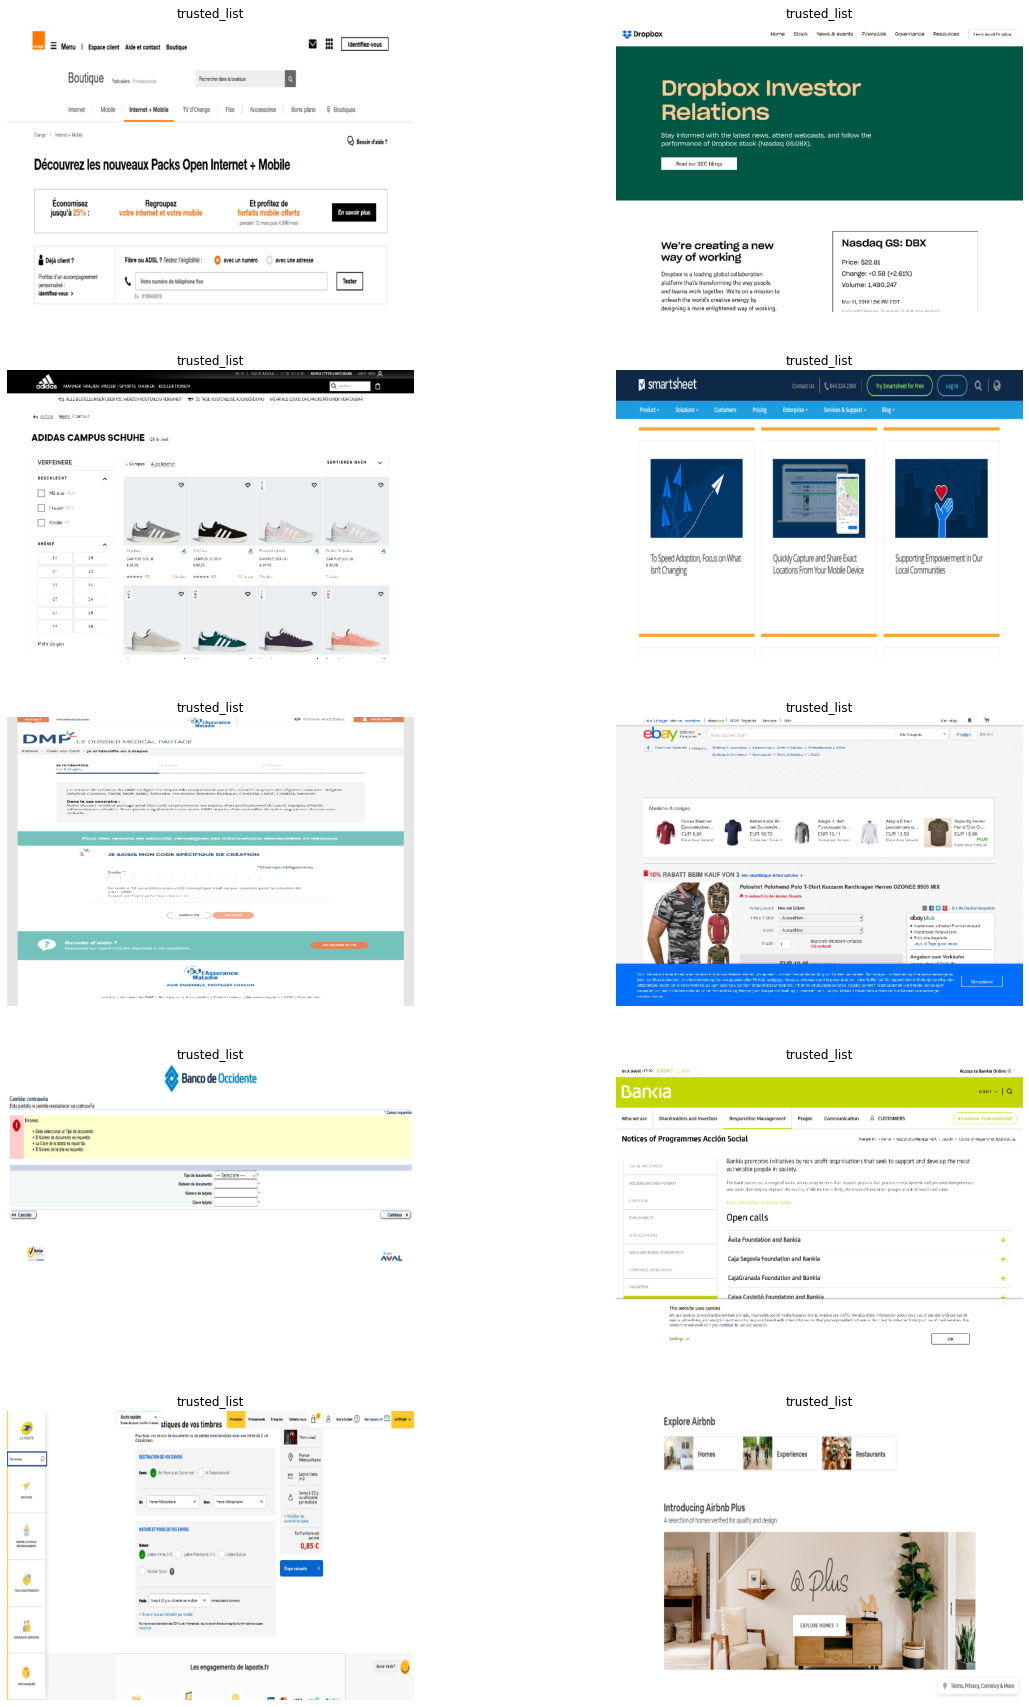

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

##Standardize the data

## Tune dataset

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(20).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.shuffle(100).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Model

In [14]:
num_classes = 2
reg_rate1 = 0.005
reg_rate2 = 0.001
dropout_prob1 = 0.2
dropout_prob2 = 0.3
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', activity_regularizer=regularizers.l2(reg_rate1)),
  # layers.MaxPool2D(pool_size=(1,2)),
  layers.MaxPool2D(),
  layers.Dropout(dropout_prob1),
  layers.Conv2D(64, 3, padding='same', activation='relu', activity_regularizer=regularizers.l2(reg_rate1)),
  layers.MaxPool2D(),
  layers.Dropout(dropout_prob1),
  layers.Conv2D(64, 2, padding='same', activation='relu', activity_regularizer=regularizers.l2(reg_rate2)),
  layers.MaxPool2D(),
  layers.Dropout(dropout_prob2),
  layers.Conv2D(128, 2, padding='same', activation='relu', activity_regularizer=regularizers.l2(reg_rate2)),
  layers.MaxPool2D(),
  layers.Dropout(dropout_prob2),
#   layers.Conv2D(128, 2, padding='same', activation='relu', activity_regularizer=regularizers.l2(reg_rate2)),
#   layers.MaxPool2D(),
#   layers.Dropout(dropout_prob2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', activity_regularizer=regularizers.l1(reg_rate2)),
  layers.Dense(num_classes-1, activity_regularizer=regularizers.l1(reg_rate2))
])


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 720, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 720, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 360, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 360, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 360, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 180, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 180, 64)      0

## Training

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [23]:
resume_epoch=0
resume_chkp_path = checkpoint_dir / "2021-07-24_02:22:00.400711_custom2_valacc0.8936_e4"

In [24]:
os.listdir(checkpoint_dir)

['2021-07-25_17;29;24.257896_custom2_valacc0.8853_e1',
 '2021-07-25_17;29;24.257896_custom2_valacc0.8853_e2',
 '2021-07-25_17;29;24.257896_custom2_valacc0.8853_e3',
 '2021-07-25_17;29;24.257896_custom2_valacc0.8853_e4',
 '2021-07-25_17;29;24.257896_custom2_valacc0.8853_e5',
 '2021-07-25_17;29;24.257896_custom2_valacc0.8853_e6',
 '2021-07-25_17;29;24.257896_custom2_valacc0.8853_e7',
 '2021-07-25_17;29;24.257896_custom2_valacc0.8853_e8',
 '2021-07-25_20;02;47.486622_custom1_valacc0.8709_e1',
 '2021-07-25_20;02;47.486622_custom1_valacc0.8891_e2',
 '2021-07-25_20;02;47.486622_custom1_valacc0.9135_e4',
 '2021-07-25_20;10;06.499228_custom1_valacc0.8910_e1',
 '2021-07-25_20;10;06.499228_custom1_valacc0.8982_e2',
 '2021-07-25_20;10;06.499228_custom1_valacc0.9077_e3',
 '2021-07-25_20;22;06.309418_custom3_valacc0.9034_e1',
 '2021-07-25_20;22;06.309418_custom3_valacc0.9039_e3',
 '2021-07-25_20;22;06.309418_custom3_valacc0.9130_e4']

In [25]:
# resume_chkp_path = tf.train.latest_checkpoint(checkpoint_dir / "2021-07-24_02:22:00.400711_custom2_valacc0.8948_e7")
print(resume_chkp_path)

..\phi_checkpoints\2021-07-24_02:22:00.400711_custom2_valacc0.8936_e4


In [26]:
epochs=20
if resume_epoch:
  # resume_chkp_path = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(resume_chkp_path)
  print(f"Resuming from {resume_chkp_path}")
  # model = keras.models.load_model(resume_chkp_path)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  initial_epoch=resume_epoch,
  callbacks=callbacks
)

resume_epoch = history.epoch[-1]

Epoch 1/20
844/844 [==============================] - 133s 147ms/step - loss: 23.4501 - accuracy: 0.8764 - val_loss: 0.7701 - val_accuracy: 0.8868

Epoch 00001: val_loss improved from inf to 0.77015, saving model to ..\phi_checkpoints\2021-07-25_20;59;24.692949_custom2_valacc0.8868_e1
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-07-25_20;59;24.692949_custom2_valacc0.8868_e1\assets
Epoch 2/20
844/844 [==============================] - 130s 143ms/step - loss: 0.5446 - accuracy: 0.8900 - val_loss: 0.4252 - val_accuracy: 0.8922

Epoch 00002: val_loss improved from 0.77015 to 0.42516, saving model to ..\phi_checkpoints\2021-07-25_20;59;24.692949_custom2_valacc0.8922_e2
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-07-25_20;59;24.692949_custom2_valacc0.8922_e2\assets
Epoch 3/20
844/844 [==============================] - 130s 143ms/step - loss: 0.3689 - accuracy: 0.8956 - val_loss: 0.3578 - val_accuracy: 0.8888

Epoch 00003: val_loss improved from 0.42516 to 0.35785

## Save model

In [27]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}_w{img_width}_h{img_height}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\phi_models\2021-07-25_20;59;24.692949_custom2_valacc0.8917_e13_b10_w720_h512.tf\assets


## Load model

In [ ]:
# change filename to the model you want to load
model_filename = "2021-07-23_10:41:26.182203_custom1_valacc0.9185_e4_b16.tf"
model2 = keras.models.load_model(
    model_dir / model_filename,
    compile=True)

## Visulaize loss and acc

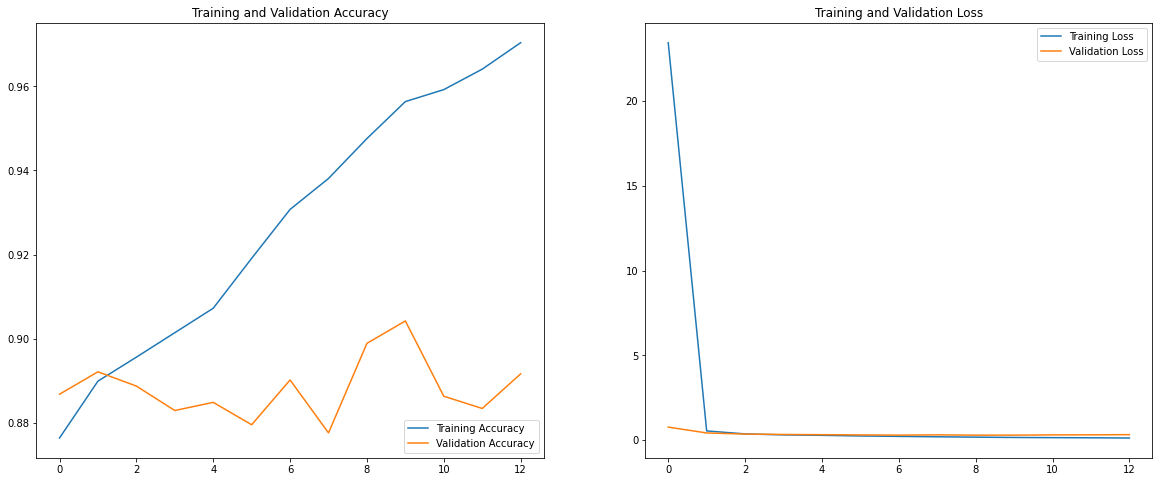

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [37]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

207/207 [==============================] - 23s 108ms/step - loss: 0.3211 - accuracy: 0.8922
val loss, val acc: [0.3211301565170288, 0.8921663165092468]


In [38]:
results = model.evaluate(test_ds, batch_size=256)
print("test loss, test acc:", results)


4/4 [==============================] - 1s 117ms/step - loss: 0.4506 - accuracy: 0.9000
test loss, test acc: [0.4505903124809265, 0.8999999761581421]
